# Graph kernels with PASQAL processor

In [1]:
import numpy as np
from utils import jensen_shannon, return_fourier_from_dataset
from data_preprocessing import load_dataset
import pickle
import networkx as nx
import grakel
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score

## Import the IMDB-MULTI dataset

We import the IMDB-MULTI dataset, limited to the graphs below 10 nodes.

Number of graphs:  814


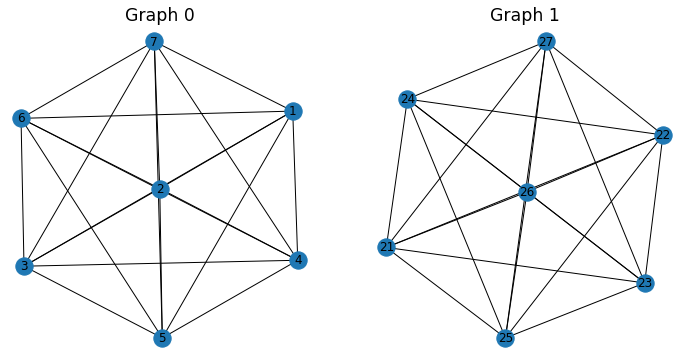

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [2]:
graphs, targets = load_dataset('IMDB-MULTI', min_node=0, max_node=10)
print("Number of graphs: ", len(graphs))

plt.figure(figsize=[12,6])
plt.subplot(121)
nx.draw(graphs[0], with_labels=True)
plt.title("Graph 0", fontsize='xx-large')
plt.subplot(122)
nx.draw(graphs[1], with_labels=True)
plt.title("Graph 1", fontsize='xx-large')
plt.show()
targets

For the rest of the demo, we will limit ourselves to a sample of 20 graphs

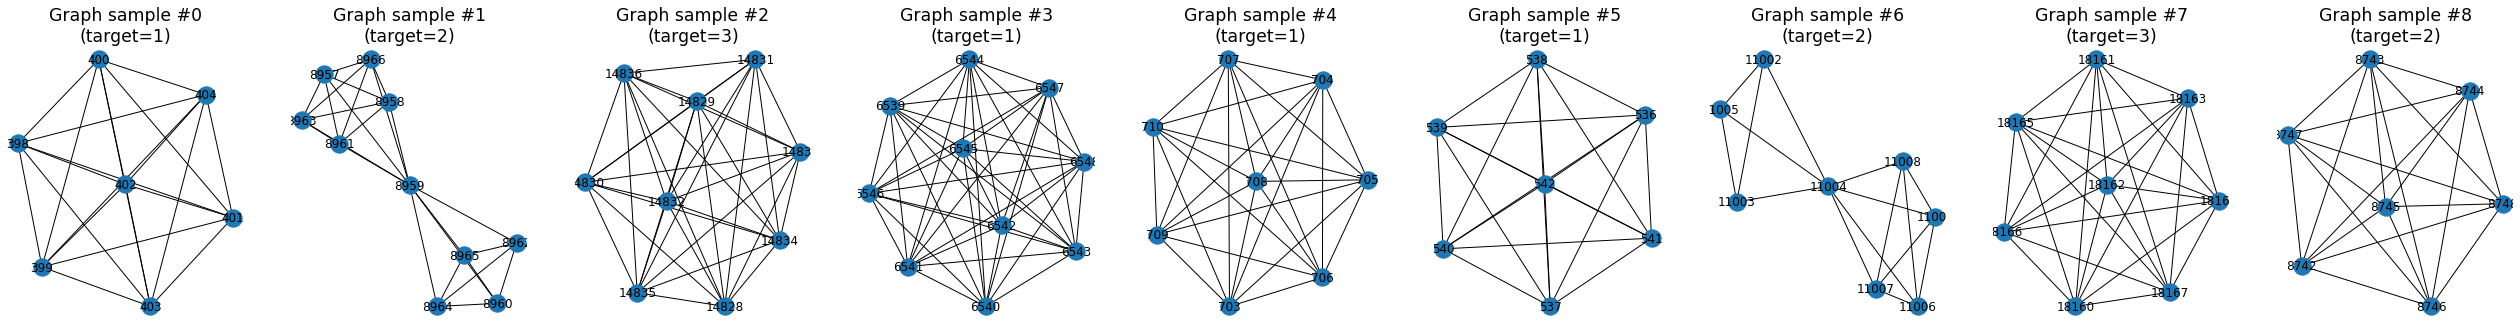

In [3]:
np.random.seed(40)
sample = np.random.choice(len(graphs), size=9, replace=False).astype(int)

graphs_sample, targets_sample = graphs[sample], targets[sample]
plt.figure(figsize=[50, 5])
for i, graph in enumerate(graphs_sample):
    plt.subplot(1, 10, 1 + i)
    nx.draw(graphs_sample[i], with_labels=True)
    plt.title(f"Graph sample #{i}\n(target={int(targets_sample[i])})", fontsize='xx-large')
plt.show()

## Generate the hamiltonian evolutions

Generate the fourier signals

In [4]:
N = 3000

In [5]:
%%time

ei = '1'
for tt in range(N - 1):
    ei += '1'

CPU times: user 386 µs, sys: 0 ns, total: 386 µs
Wall time: 392 µs


In [6]:
%%time 
ej = '1' * N

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [7]:
ei == ej

True

In [8]:
%%time
l1 = ['i' for _ in range(N)]

CPU times: user 89 µs, sys: 5 µs, total: 94 µs
Wall time: 95.1 µs


In [9]:
%%time 
l2 = ['i'] * N

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 4.77 µs


In [10]:
l1 == l2

True

In [11]:
#Relabel the nodes
graphs_sample = [nx.convert_node_labels_to_integers(G) for G in graphs_sample]
graphs_sample = np.array(graphs_sample, dtype=object)

#Generate signals
fourier_xy, fourier_ising = return_fourier_from_dataset(graphs_sample)

/Users/romainfouilland/code/qgraph/utils.py:175: ComplexWarning: Casting complex values to real discards the imaginary part
  fs_xy[0][i], fs_xy[1][i] = generate_signal_fourier(graph,
/Users/romainfouilland/code/qgraph/utils.py:179: ComplexWarning: Casting complex values to real discards the imaginary part
  fs_is[0][i], fs_is[1][i] = generate_signal_fourier(graph,


Discretize into histograms

In [12]:
histograms_xy = []
histograms_ising = []

for i in range(len(graphs_sample)):
    # np.hist: 0 = weights, 1 = freqs
    histograms_xy.append(np.histogram(fourier_xy[1,i], bins=500, weights=np.abs(fourier_xy[0,i])**2, density=True))
    histograms_ising.append(np.histogram(fourier_ising[1,i], bins=500, weights=np.abs(fourier_ising[0,i])**2, density=True))

In [13]:
histograms_xy[0][1], histograms_xy[0][0]

(array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ,  1.02,  1.04,  1.06,
         1.08,  1.1 ,  1.12,  1.14,  1.16,  1.18,  1.2 ,  1.22,  1.24,
         1.26,  1.28,  1.3 ,  1.32,  1.34,  1.36,  1.38,  1.4 ,  1.42,
         1.44,  1.46,  1.48,  1.5 ,  1.52,  1.54,  1.56,  1.58,  1.6 ,
         1.62,  1.64,  1.66,  1.68,  1.7 ,  1.72,  1.74,  1.76,  1.78,
         1.8 ,  1.82,  1.84,  1.86,  1.88,  1.9 ,  1.92,  1.94,  1.96,
         1.98,  2.  ,  2.02,  2.04,  2.06,  2.08,  2.1 ,  2.12,  2.14,
         2.16,  2.18,  2.2 ,  2.22,  2.24,  2.26,  2.28,  2.3 ,  2.32,
         2.34,  2.36,  2.38,  2.4 ,  2.42,  2.44,  2.46,  2.48,  2.5 ,
      

Plot some histograms of XY evolution

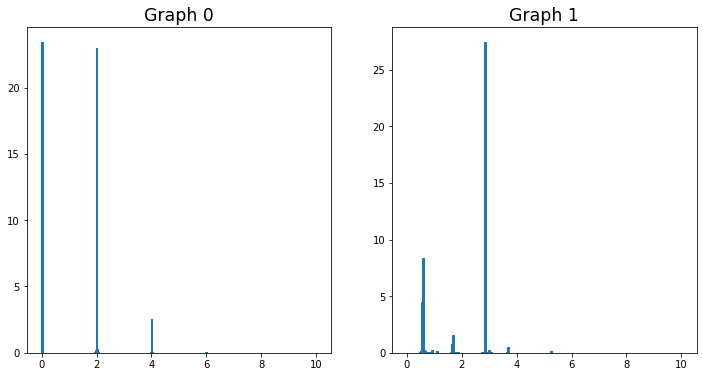

In [14]:
plt.figure(figsize=[12,6])
plt.subplot(121)
plt.bar(histograms_xy[0][1][1::], histograms_xy[0][0], width=0.1)
plt.title("Graph 0", fontsize='xx-large')
plt.subplot(122)
plt.bar(histograms_xy[1][1][1::], histograms_xy[1][0], width=0.1)
plt.title("Graph 1", fontsize='xx-large')
plt.show()

## Compute the distance matrices

In [15]:
# Initialize empty matrices
js_xy = np.zeros((len(graphs_sample), len(graphs_sample)))
js_ising = np.zeros((len(graphs_sample), len(graphs_sample)))

for i in range(len(graphs_sample)):
    for j in range(i, len(graphs_sample)):
        js_xy[i,j] = jensen_shannon(histograms_xy[i], histograms_xy[j])
        js_ising[i,j] = jensen_shannon(histograms_ising[i], histograms_ising[j])
        js_xy[j,i] = js_xy[i,j]
        js_ising[j,i] = js_ising[i,j]

## Compute the classical kernels

In [46]:
#Turn the graphs into grakel.Graph objects
graphs_grakel = [grakel.Graph(nx.adjacency_matrix(graph)) for graph in graphs_sample]

rw_kernel = grakel.RandomWalk(lamda=0.001)
gs_kernel = grakel.GraphletSampling(k=6, sampling={'n_samples':100})
lt_kernel = grakel.LovaszTheta()

K_rw = rw_kernel.fit_transform(graphs_grakel)
K_gs = gs_kernel.fit_transform(graphs_grakel)
K_lt = lt_kernel.fit_transform(graphs_grakel)

## Fit the models

In [47]:
p = 0.2
mu = 10
C = 10

#Compute the quantum kernel from the distances matrices
K_q = np.exp(-mu * (p * js_xy + (1-p) * js_ising))

#Initialize the classifier
clf = svm.SVC(kernel='precomputed', C=C, random_state=76)

#Perform a 3-fold cross-validation for every kernel
scores_q = cross_val_score(clf, K_q, targets_sample, cv=3, scoring=make_scorer(f1_score, average='weighted'))
scores_rw = cross_val_score(clf, K_rw, targets_sample, cv=3, scoring=make_scorer(f1_score, average='weighted'))
scores_gs = cross_val_score(clf, K_gs, targets_sample, cv=3, scoring=make_scorer(f1_score, average='weighted'))
scores_lt = cross_val_score(clf, K_lt, targets_sample, cv=3, scoring=make_scorer(f1_score, average='weighted'))

print("Mean of F1 score for quantum kernel: ", np.mean(scores_q))
print("Mean of F1 score for RW kernel: ", np.mean(scores_rw))
print("Mean of F1 score for GS kernel: ", np.mean(scores_gs))
print("Mean of F1 score for LT kernel: ", np.mean(scores_lt))



Mean of F1 score for quantum kernel:  0.4259259259259259
Mean of F1 score for RW kernel:  0.2407407407407407
Mean of F1 score for GS kernel:  0.27777777777777773
Mean of F1 score for LT kernel:  0.25925925925925924


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less tha

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less tha

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less tha

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less tha

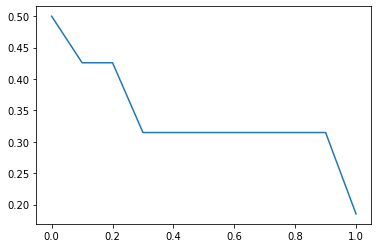

In [48]:
ps = np.linspace(0, 1, 11)
scores_p = []
for p in ps:
    scores_p_loop = []
    for _ in range(10):
        #Compute the quantum kernel from the distances matrices
        K_q = np.exp(-mu * (p * js_xy + (1-p) * js_ising))

        #Initialize the classifier
        clf = svm.SVC(kernel='precomputed', C=C, random_state=76)

        #Perform a 3-fold cross-validation for every kernel
        scores_q = cross_val_score(clf, K_q, targets_sample, cv=3, scoring=make_scorer(f1_score, average='weighted'))
    
        scores_p_loop.append(np.mean(scores_q))
    scores_p.append(scores_p_loop)
plt.plot(ps, np.mean(scores_p, axis=1))

In [52]:
scores = []
for _ in range(10):
    K_rw = rw_kernel.fit_transform(graphs_grakel)
    scores_rw = cross_val_score(clf, K_rw, targets_sample, cv=3, scoring=make_scorer(f1_score, average='weighted'))
    scores.append(np.mean(scores_rw))
print(f'{np.mean(scores)} ± {np.std(scores):.2f}')

scores = []
for _ in range(10):
    K_gs = gs_kernel.fit_transform(graphs_grakel)
    scores_gs = cross_val_score(clf, K_gs, targets_sample, cv=3, scoring=make_scorer(f1_score, average='weighted'))
    scores.append(np.mean(scores_gs))
print(f'{np.mean(scores)} ± {np.std(scores):.2f}')

scores = []
for _ in range(10):
    K_lt = lt_kernel.fit_transform(graphs_grakel)
    scores_lt = cross_val_score(clf, K_lt, targets_sample, cv=3, scoring=make_scorer(f1_score, average='weighted'))
    scores.append(np.mean(scores_lt))
print(f'{np.mean(scores)} ± {np.std(scores):.2f}')

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less tha

0.24074074074074064 ± 0.00


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less tha

0.4 ± 0.15


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less tha

0.18888888888888888 ± 0.08


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
